In [2]:
import os
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization, PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pathlib

2025-05-08 14:45:49.430235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 14:45:49.439285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746704749.448759   86617 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746704749.451768   86617 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746704749.459666   86617 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
img_path = 'data/my_dataset/img/unknown/'
img_size_lr = (24, 24)
img_size_hr = (96, 96)
batch_size = 16
epochs = 50
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def preprocess(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    hr = tf.image.resize(img, img_size_hr)
    lr = tf.image.resize(hr, img_size_lr)
    lr = tf.cast(lr, tf.float32) / 255.0
    hr = tf.cast(hr, tf.float32) / 255.0
    return lr, hr

#### Load model

In [36]:
def load_fh_model(model, model_name):
    model.load_weights(model_name)
    return model

In [10]:
def load_images(path, img_size):
    images = []
    for i in range(1, 100):
        filename = f'{img_path}{i}.jpg'
        img = load_img(filename, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

In [11]:
def show_results(lr, sr, hr, index=0):
    plt.figure(figsize=(12,4))
    titles = ['Low-res', 'Super-res', 'High-res']
    for i, img in enumerate([lr[index], sr[index], hr[index]]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [41]:
def residual_block(x_in, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.Add()([x_in, x])

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)
    
def build_fnet_model():
    inputs = tf.keras.layers.Input(shape=(24, 24, 3))
    x = tf.keras.layers.Conv2D(64, 9, padding='same')(inputs)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    skip = x
    for _ in range(5):
        x = residual_block(x, 64)
    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, skip])

    x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
    x = tf.keras.layers.Lambda(
        lambda x: tf.nn.depth_to_space(x, 2),
        output_shape=lambda s: (s[0], s[1]*2, s[2]*2, s[3]//4)
    )(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
    x = tf.keras.layers.Lambda(
        lambda x: tf.nn.depth_to_space(x, 2),
        output_shape=lambda s: (s[0], s[1]*2, s[2]*2, s[3]//4)
    )(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    x = tf.keras.layers.Conv2D(3, 9, padding='same', activation='sigmoid')(x)
    return tf.keras.models.Model(inputs, x)



In [5]:
all_files = list(pathlib.Path(img_path).rglob("*.jpg"))
split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files = all_files[split:]
ds_train = tf.data.Dataset.from_tensor_slices([str(p) for p in train_files])
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices([str(p) for p in val_files])
ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

In [7]:
def build_cface():
    inputs = Input(shape=(24, 24, 3))
    x = Conv2D(64, 5, padding='same')(inputs)
    x = PReLU()(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(3, 3, activation='sigmoid', padding='same')(x)
    model = Model(inputs, x)
    return model

**SRGAN**

In [1]:
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=5):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 9, stride=1, padding=4),
            nn.PReLU()
        )
        res_blocks = []
        for _ in range(num_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        self.mid = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        # Conv2d upscale chanels (з 64 → 256).
        self.upscale = nn.Sequential(
            nn.Conv2d(64, 256, 3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, 3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        # 64 chanels to RGB
        self.final = nn.Conv2d(64, 3, 9, stride=1, padding=4)

    def forward(self, x):
        x_initial = self.initial(x)
        x = self.res_blocks(x_initial)
        x = self.mid(x)
        x = x + x_initial
        x = self.upscale(x)
        x = self.final(x)
        return x


In [8]:
model = build_cface()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 24, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 24, 24, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 24, 24, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 48, 48, 64)     │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 96, 96, 64)     │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 855,363 (3.26 MB)

 Trainable params: 854,979 (3.26 MB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val
)
# Save model
model.save("CNet_24.keras")

Epoch 1/50


I0000 00:00:1746704840.949905   99524 service.cc:152] XLA service 0x716fac025f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746704840.949936   99524 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-05-08 14:47:20.995309: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746704841.189741   99524 cuda_dnn.cc:529] Loaded cuDNN version 90300


   16/10491 ━━━━━━━━━━━━━━━━━━━━ 1:50 11ms/step - loss: 0.0643

I0000 00:00:1746704843.721607   99524 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10491/10491 ━━━━━━━━━━━━━━━━━━━━ 128s 12ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 2/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 124s 12ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 124s 12ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 124s 12ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 122s 12ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 125s 12ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 124s 12ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/50
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 121s 12ms/step - loss: 0.0023 - val

In [3]:
model = load_fh_model(build_cface(), "CNet_24.keras")

NameError: name 'load_fh_model' is not defined

In [2]:
model = load_fh_model(build_fnet_model(), "FNet_24.keras")
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


NameError: name 'load_fh_model' is not defined

In [ ]:
model = build_fnet_model()
EPOCHS = 2
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fnet_model.keras', save_best_only=True)
]

In [68]:
EPOCHS = 10
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks
)
# Save model
model.save("FNet_24.keras")

Epoch 1/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 241s 23ms/step - loss: 0.0018 - mae: 0.0244 - val_loss: 0.0019 - val_mae: 0.0245
Epoch 2/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 235s 22ms/step - loss: 0.0018 - mae: 0.0244 - val_loss: 0.0019 - val_mae: 0.0244
Epoch 3/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 235s 22ms/step - loss: 0.0018 - mae: 0.0243 - val_loss: 0.0018 - val_mae: 0.0244
Epoch 4/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 235s 22ms/step - loss: 0.0018 - mae: 0.0243 - val_loss: 0.0018 - val_mae: 0.0243
Epoch 5/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 235s 22ms/step - loss: 0.0018 - mae: 0.0242 - val_loss: 0.0018 - val_mae: 0.0242
Epoch 6/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 236s 22ms/step - loss: 0.0018 - mae: 0.0242 - val_loss: 0.0018 - val_mae: 0.0242
Epoch 7/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 236s 22ms/step - loss: 0.0018 - mae: 0.0242 - val_loss: 0.0018 - val_mae: 0.0241
Epoch 8/10
10491/10491 ━━━━━━━━━━━━━━━━━━━━ 236s 23ms/step - loss: 0.0018 - mae: 0.0241 - val_loss: 0.0018 - val_mae: 0.0242


In [69]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 24, 24, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 24, 24,    │     15,616 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_44 (PReLU)  │ (None, 24, 24,    │         64 │ conv2d_76[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 24, 24,    │     36,928 │ p_re_lu_44[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_45 (PReLU)  │ (None, 24, 24,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 24, 24,    │     36,928 │ p_re_lu_45[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 24, 24,    │          0 │ p_re_lu_44[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 24, 24,    │     36,928 │ add_24[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_46 (PReLU)  │ (None, 24, 24,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 24, 24,    │     36,928 │ p_re_lu_46[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 24, 24,    │          0 │ add_24[0][0],     │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 24, 24,    │     36,928 │ add_25[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_81[0][0] 

 Total params: 2,205,579 (8.41 MB)

 Trainable params: 734,723 (2.80 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 1,469,448 (5.61 MB)

In [65]:
# Load model
model = load_fh_model(build_fnet_model(), "FNet_24.keras")

In [70]:
lr_images = load_images(img_path, img_size_lr)
hr_images = load_images(img_path, img_size_hr)

In [71]:
sr_images = model.predict(lr_images)

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/stepWARNING:tensorflow:5 out of the last 20 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x716f247ccb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


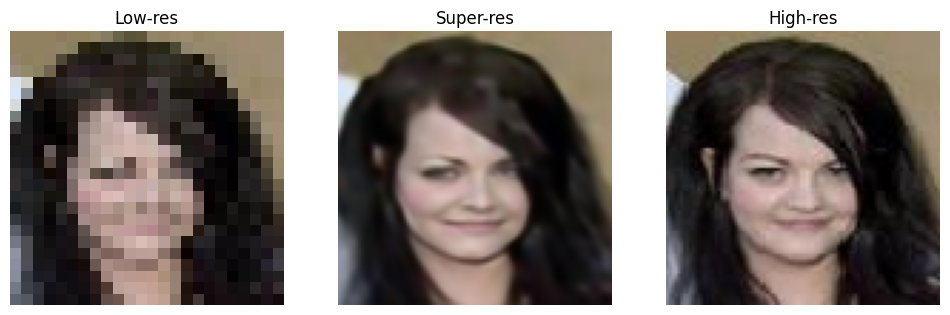

In [72]:

show_results(lr_images, sr_images, hr_images, index = 86)

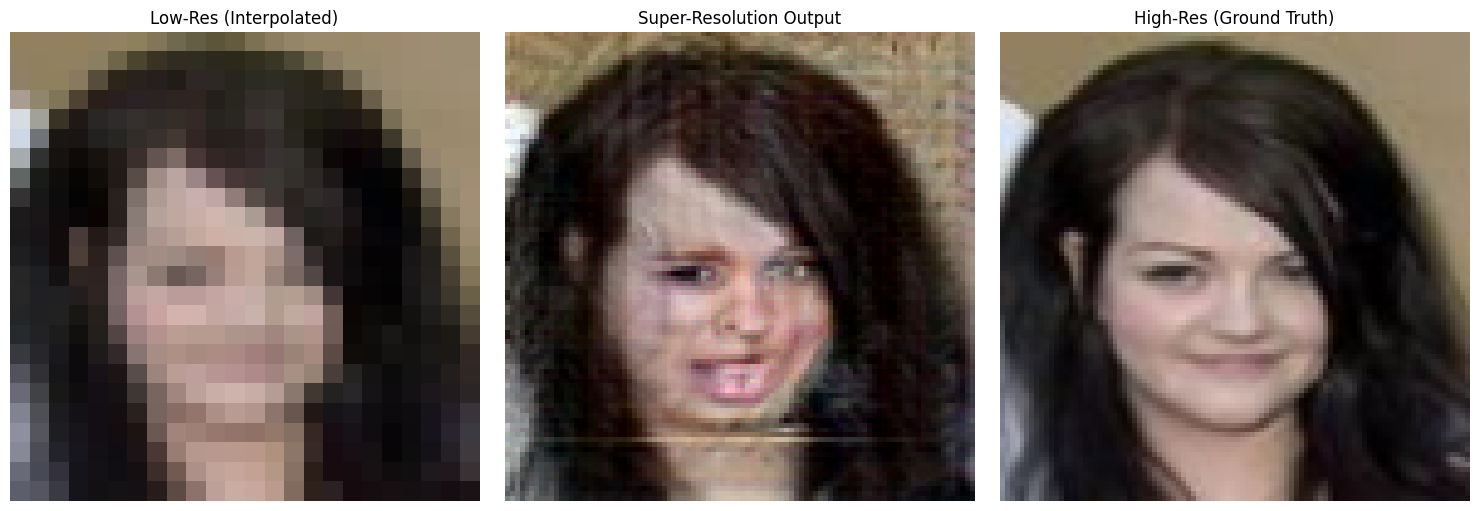

In [81]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# choice device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_path = "data/my_dataset/img/unknown/87.jpg"
image = Image.open(image_path).convert("RGB")

#  high-resolution (HR)
transform_hr = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# low-resolution (LR)
transform_lr = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.ToTensor()
])

img_hr = transform_hr(image).unsqueeze(0).to(device)  # (1, 3, 96, 96)
img_lr = transform_lr(image).unsqueeze(0).to(device)  # (1, 3, 24, 24)

generator = Generator().to(device)
generator.load_state_dict(torch.load('./best_generator_20.pth'))
generator.eval()

# generate SR
with torch.no_grad():
    img_sr = generator(img_lr)

def tensor_to_image(tensor):
    tensor = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    tensor = (tensor * 255).clip(0, 255).astype("uint8")
    return tensor

img_lr_up = F.interpolate(img_lr, size=(96, 96), mode='bicubic', align_corners=False)

img_lr_np = tensor_to_image(img_lr)
img_sr_np = tensor_to_image(img_sr)
img_hr_np = tensor_to_image(img_hr)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_lr_np)
plt.title('Low-Res (Interpolated)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_sr_np)
plt.title('Super-Resolution Output')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_hr_np)
plt.title('High-Res (Ground Truth)')
plt.axis('off')

plt.tight_layout()
plt.show()
